# SUPPLY DATA ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
df = pd.read_csv(r"C:\Users\Akshaya\OneDrive\Desktop\Xcelerate\chat_gpt\supplies_data.csv")

df["sales_date"] = pd.to_datetime(df["sales_date"])

df = df.sort_values("sales_date")

print(df.head())

   order_id  product_id sales_date  quantity_sold  unit_price  total_sales  \
0        51          16 2024-01-01              3       75.28       225.84   
1        52          29 2024-01-02              8       50.94       407.52   
2        53          24 2024-01-03              6       94.94       569.64   
3        54          20 2024-01-04              3       31.00        93.00   
4        55          17 2024-01-05              1       47.29        47.29   

   supplier_id supply_date  supplied_quantity  
0            5  2023-12-26                  6  
1            4  2023-12-24                 11  
2            1  2023-12-25                  8  
3            4  2023-12-25                  5  
4            3  2023-12-29                  5  


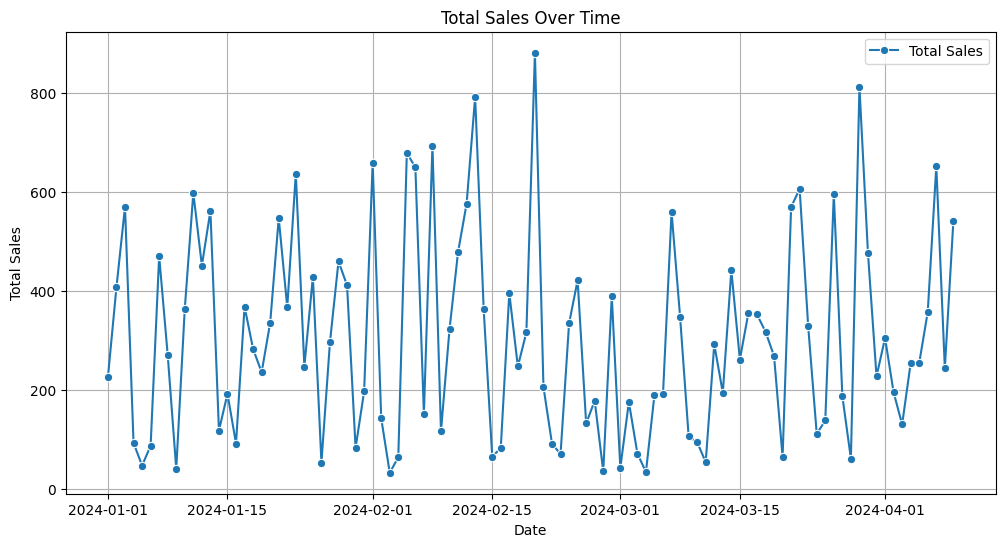

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="sales_date", y="total_sales", marker="o", label="Total Sales")
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid()
plt.legend()
plt.show()

## PROPHET MODEL

In [ ]:

prophet_df = df[["sales_date", "total_sales"]].rename(columns={"sales_date": "ds", "total_sales": "y"})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=10)
forecast = prophet_model.predict(future)

09:53:31 - cmdstanpy - INFO - Chain [1] start processing
09:53:31 - cmdstanpy - INFO - Chain [1] done processing


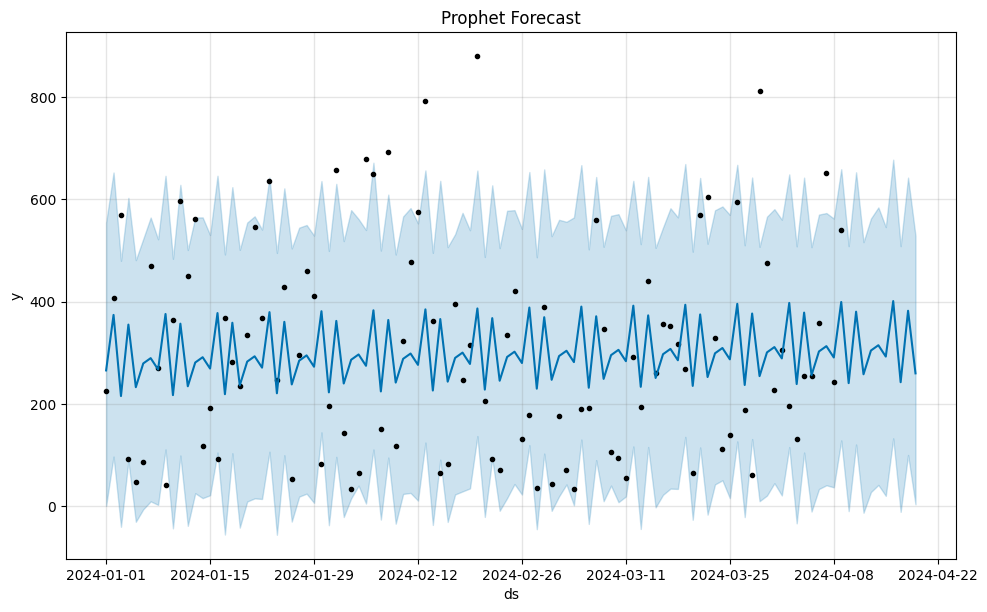

In [ ]:

prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

## ARIMA MODEL

In [26]:
arima_model = ARIMA(df["total_sales"], order=(2,1,2))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=10)

c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


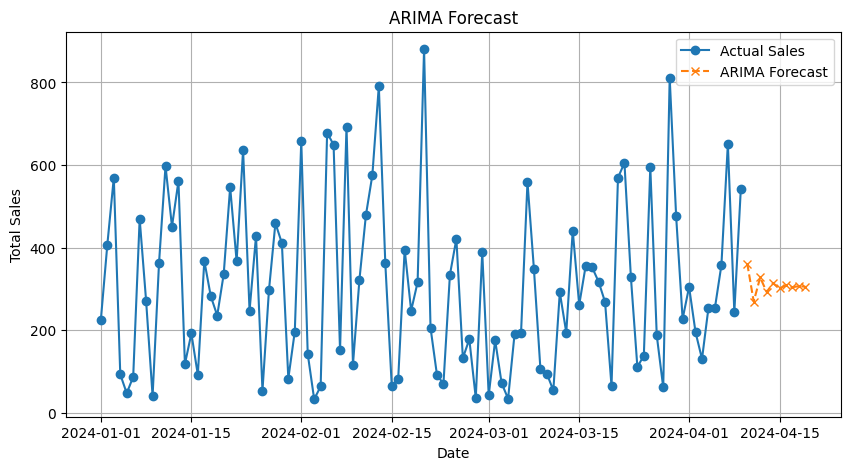

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(df["sales_date"], df["total_sales"], marker="o", label="Actual Sales")
plt.plot(pd.date_range(start=df["sales_date"].iloc[-1], periods=11, freq="D")[1:], forecast_arima, linestyle="dashed", marker="x", label="ARIMA Forecast")
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid()
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(df["total_sales"].values.reshape(-1, 1))


def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 3
X, y = create_sequences(scaled_sales, seq_length)
X_train, y_train = torch.Tensor(X), torch.Tensor(y)


In [ ]:



X_train = X_train.reshape(X_train.shape[0], seq_length, 1)


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, h = self.gru(x)  
        return self.fc(h[-1]) 


gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = gru_model(X_train)  
    loss = criterion(output, y_train.unsqueeze(-1))
    loss.backward()
    optimizer.step()


X_test = torch.Tensor(scaled_sales[-seq_length:].reshape(1, seq_length, 1))
gru_forecast = gru_model(X_test).detach().numpy()
gru_forecast = scaler.inverse_transform(gru_forecast.reshape(-1, 1))

gru_forecast


c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([97, 1, 1])) that is different to the input size (torch.Size([97, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


array([[303.57587]], dtype=float32)

In [ ]:

forecast_arima, forecast.tail(10)["yhat"], gru_forecast

(100    361.516596
 101    269.520198
 102    327.762405
 103    292.620909
 104    313.801154
 105    301.035861
 106    308.729474
 107    304.092551
 108    306.887214
 109    305.202877
 Name: predicted_mean, dtype: float64,
 100    240.631417
 101    380.379448
 102    257.941602
 103    304.408750
 104    314.758612
 105    292.577341
 106    401.134253
 107    242.436320
 108    382.184351
 109    259.746506
 Name: yhat, dtype: float64,
 array([[303.57587]], dtype=float32))